# Importing Stuff

In [78]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

# Setting constants

In [79]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

# Creating tf.dataset

In [80]:
potato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\College Stuff\TY\ML\MP\Dataset\Potato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [81]:
class_names = potato_dataset.class_names
class_names

['Early_blight', 'Healthy', 'Late_blight']

In [82]:
len(potato_dataset)

68

In [83]:
for image_batch, labels_batch in potato_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 0 0 0 0 0 2 2 2 2 0 2 0 2 2 2 0 2 0 2 0 0 2 0 0 1 2 2 0 0]


# Dataset Visualization

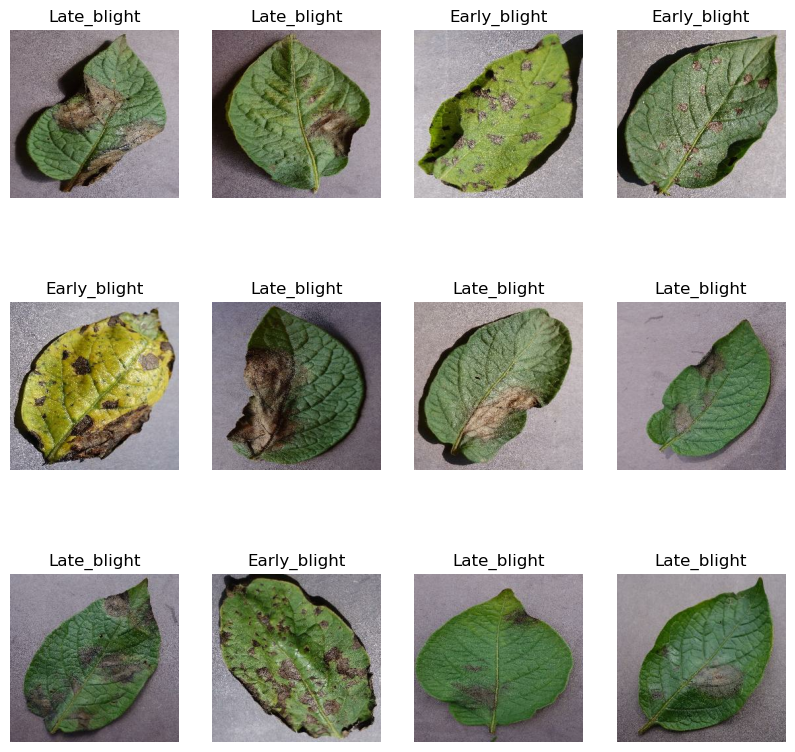

In [84]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in potato_dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Train-Test Split

In [85]:
len(potato_dataset)

68

In [86]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [87]:
potato_train, potato_val, potato_test = get_dataset_partitions_tf(potato_dataset)

In [88]:
len(potato_dataset), len(potato_train), len(potato_val), len(potato_test)

(68, 54, 6, 8)

### Cache Suffle Prefetch

In [89]:
train_ds = potato_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = potato_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = potato_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing, Rescaling

In [90]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [91]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [92]:
potato_train = potato_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [93]:
potato_train = potato_train.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model: CNN

In [94]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [95]:
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

### Compiling the model

In [96]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [97]:
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.99:
            print('The model has reached the accuracy desired (0.99), stop the training!')
            self.model.stop_training = True

In [98]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks = TrainingCallback()
)

Epoch 1/30
54/54 [==============================] - 95s 2s/step - loss: 0.8993 - accuracy: 0.4792 - val_loss: 0.8171 - val_accuracy: 0.6719
Epoch 2/30
54/54 [==============================] - 82s 2s/step - loss: 0.6875 - accuracy: 0.7083 - val_loss: 0.4498 - val_accuracy: 0.8594
Epoch 3/30
54/54 [==============================] - 81s 1s/step - loss: 0.3846 - accuracy: 0.8397 - val_loss: 0.3453 - val_accuracy: 0.8385
Epoch 4/30
54/54 [==============================] - 83s 2s/step - loss: 0.1984 - accuracy: 0.9178 - val_loss: 0.1248 - val_accuracy: 0.9479
Epoch 5/30
54/54 [==============================] - 80s 1s/step - loss: 0.1921 - accuracy: 0.9277 - val_loss: 0.0567 - val_accuracy: 0.9948
Epoch 6/30
54/54 [==============================] - 76s 1s/step - loss: 0.0958 - accuracy: 0.9635 - val_loss: 0.0489 - val_accuracy: 0.9844
Epoch 7/30
54/54 [==============================] - 74s 1s/step - loss: 0.0889 - accuracy: 0.9682 - val_loss: 0.0328 - val_accuracy: 0.9948
Epoch 8/30
54/54 [==

In [99]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 256ms/step - loss: 0.0438 - accuracy: 0.9871


In [100]:
scores

[0.043835919350385666, 0.9870689511299133]

Accuracy and Loss Curves

In [101]:
history

In [102]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [103]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [104]:
epochs_trained = len(history.history['loss'])

In [105]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8992912173271179,
 0.687539279460907,
 0.384602427482605,
 0.19835735857486725,
 0.19207264482975006]

In [106]:
for key in history.history:
    last_value = history.history[key][-1]
    print(key, ":", last_value)

loss : 0.016865720972418785
accuracy : 0.9942129850387573
val_loss : 0.0016857899026945233
val_accuracy : 1.0


In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

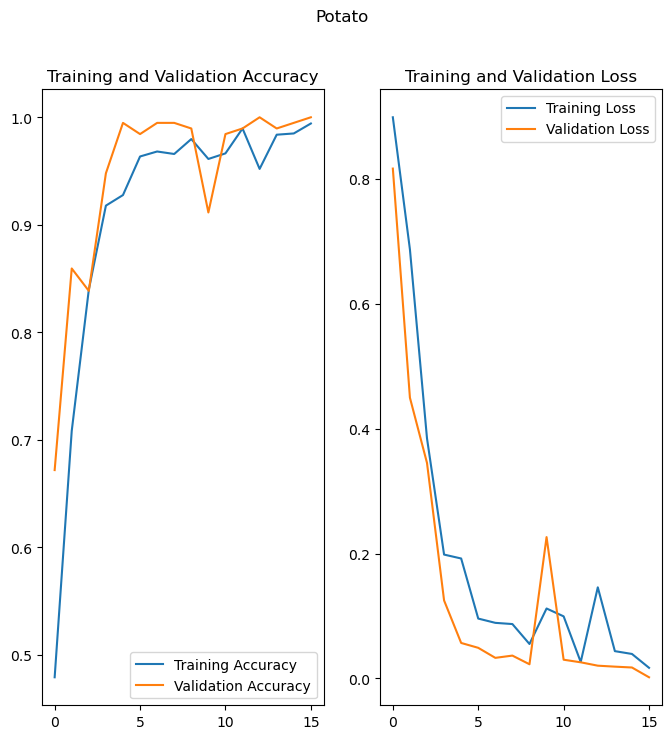

In [108]:
plt.figure(figsize=(8, 8))
plt.suptitle("Potato")
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late_blight
1/1 [==============================] - 0s 213ms/step
predicted label: Late_blight


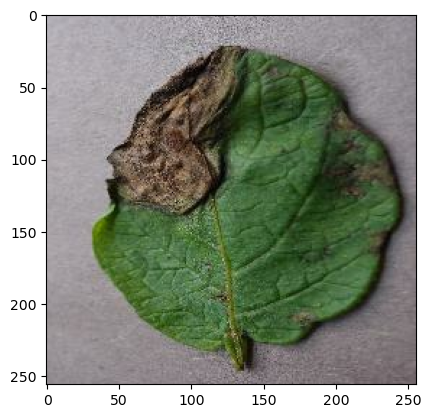

In [109]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [110]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


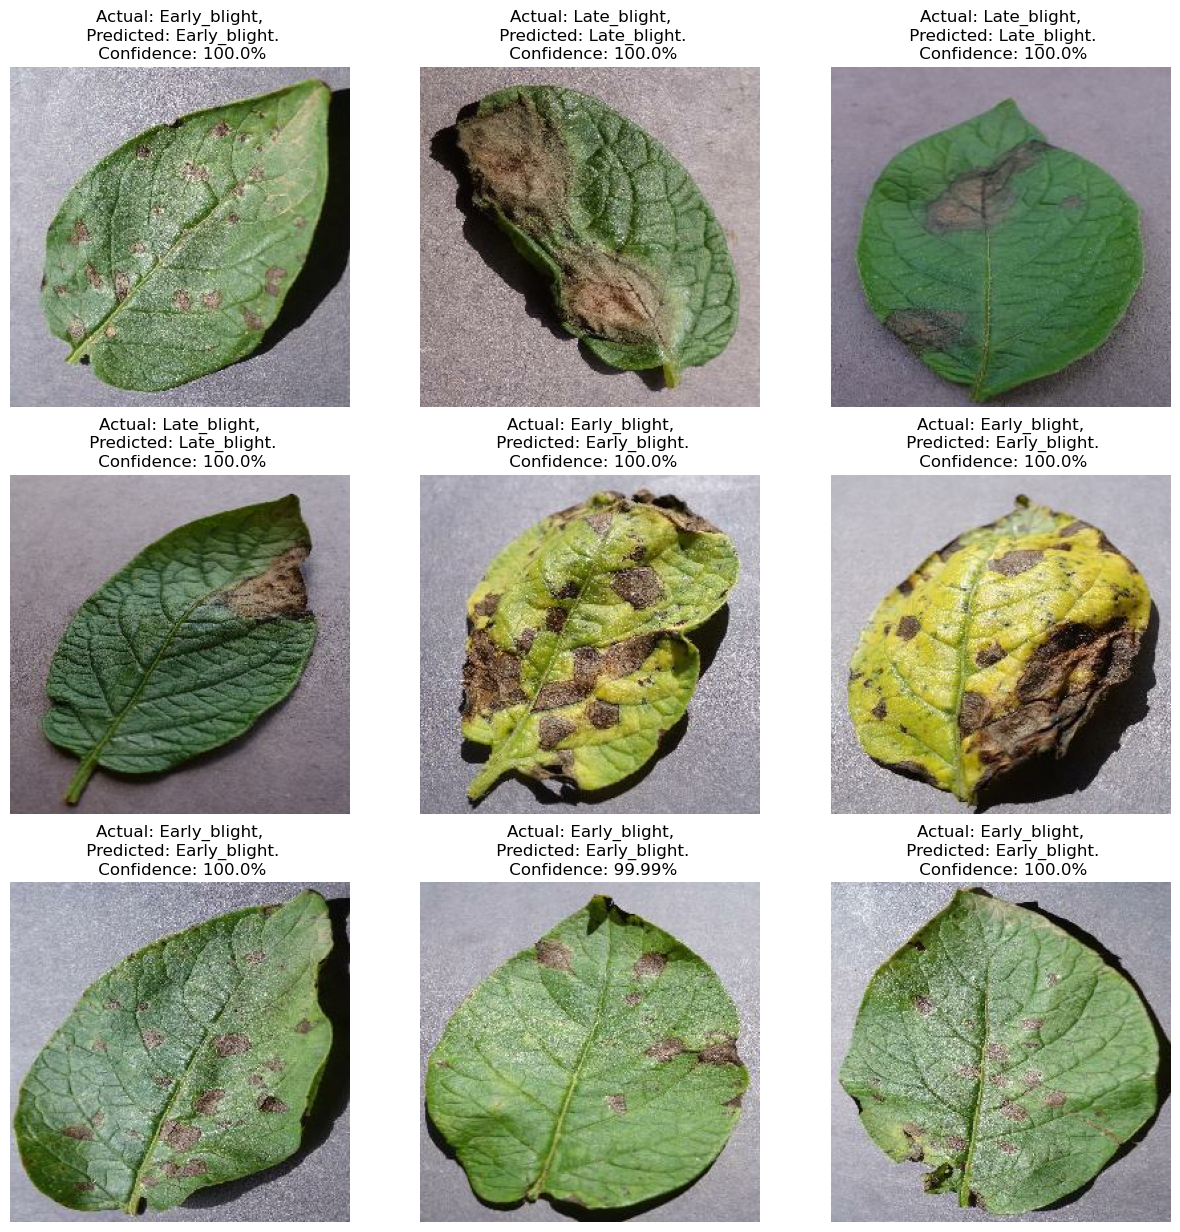

In [111]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [112]:
model.save(r'D:\College Stuff\TY\ML\MP\Main\Models\potato_cnn.h5')

In [113]:
import os
model.save("D:\College Stuff\TY\ML\MP\Main\Models\Potato")

INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Potato\assets


INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Potato\assets


In [114]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 277ms/step


In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5, 1.0, 'Potato')

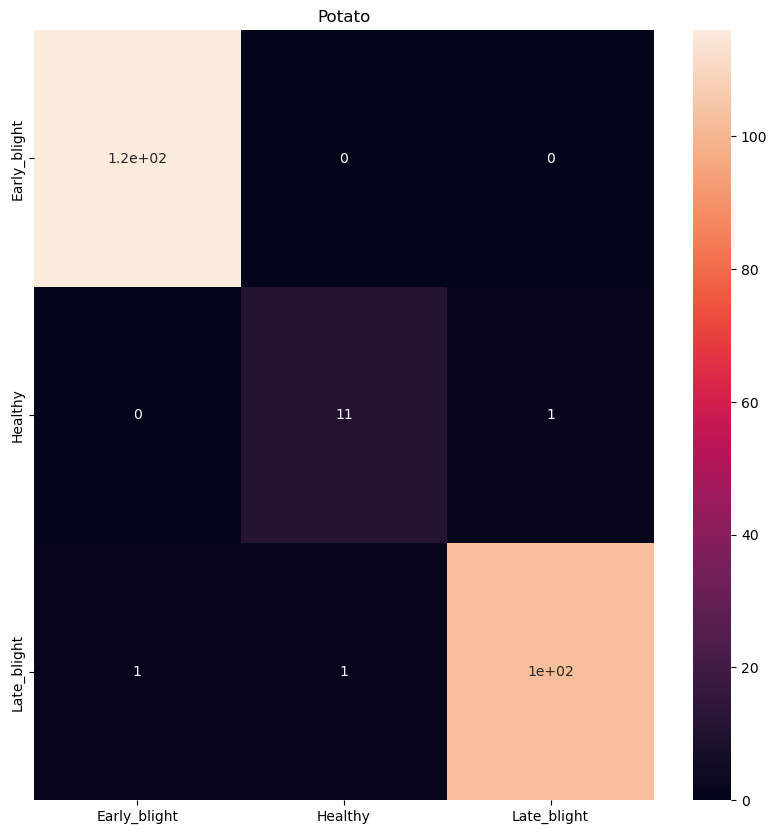

In [116]:
plt.figure(figsize=(10, 10))
potato_cm = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
graph_labels = ['Early_blight', 'Healthy', 'Late_blight']
sns.heatmap(potato_cm, annot = True, xticklabels=graph_labels, yticklabels=graph_labels)
plt.title("Potato")

In [117]:
potato_cm

array([[116,   0,   0],
       [  0,  11,   1],
       [  1,   1, 102]], dtype=int64)

In [118]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [119]:
f1_val = f1_score(y_true=correct_labels, y_pred=predicted_labels, average = None)
print("F-1 Scores: ", f1_val)

F-1 Scores:  [0.99570815 0.91666667 0.98550725]
